In [1]:
using Kinetic

┌ Info: Precompiling Kinetic [82403725-3cee-4f7c-b214-1ce71af4a797]
└ @ Base loading.jl:1278


In [12]:
# Number of spatial cells per dimension
nx = 100
ny = 100

# cfl number
cfl = 0.95

# Quadrature type and order.
# Type must be 1 for "standard" or 2 for "octa" and 3 for "ico".
quadraturetype = 2

# Quadrature order determines the number of quadrature points
quadratureorder = 6

# Convolution? Will be turned off if magnitude = 0
convolutionmagnitude = 0
convolutionwidth = 0
convolutiontoscattering = 1

# Rotation = 0 yields SN 
rotationmagnitude = 0

# linesource id 1 , checkearboard id 2
testcaseid = 1

# periodic bc? if not then vacuum
periodicXflag = 0
periodicYflag = 0

# 1D simulation flag (no real y direction)
dim1flag = 0

# perform low rank computation? Only if rank>0
whichrank = 0

0

In [80]:
SigmaS = 1*ones(ny+4,nx+4);
SigmaA = 0*ones(ny+4,nx+4);
SigmaT = SigmaS+SigmaA;
x0 = -1.5; x1 =  1.5;  y0 = -1.5; y1 =  1.5
dx = (x1-x0)/(nx)
dy = (y1-y0)/(ny)
tEnd = 1.0

pspace = PSpace2D(x0, x1, nx, y0, y1, ny);

In [81]:
points, triangulation = octa_quadrature(quadratureorder)
weights = Kinetic.quadrature_weights(points, triangulation);

In [82]:
nquadpoints = size(points, 1);
nq = nquadpoints

102

In [84]:
# initial distribution
phi = zeros(nq,nx,ny)
s2 = 0.03^2
floor = 1e-4
f(x,y) = max(floor,1.0/(4.0*pi*s2) *exp(-(x^2+y^2)/4.0/s2));
for j=1:nx
    for i=1:ny   
        y = y0+dy/2 + (i-3)*dy
        x = x0+dx/2 + (j-3)*dx     
        for q=1:nq
            phi[q,i,j] = f(x,y)/4.0/pi;
        end
    end
end

In [99]:
dt = cfl/2*(dx*dy)/(dx+dy)
t=0.

0.0

In [100]:
flux1 = zeros(nq,nx+1,ny)
flux2 = zeros(nq,nx,ny+1);

In [114]:
for iter=1:10

    for i=2:nx, j=1:ny
        tmp = @view flux1[:,i,j]
        flux_kfvs!(tmp, phi[:,i-1,j], phi[:,i,j], points[:,1], dt)
    end
    for i=1:nx, j=2:ny
        tmp = @view flux2[:,i,j]
        flux_kfvs!(tmp, phi[:,i,j-1], phi[:,i,j], points[:,2], dt)
    end
    
    for j=1:ny,i=1:nx
        #integral = discrete_moments(phi[:,i,j], weights)
        #integral *= 1.0/4.0/pi;

        for q=1:nq
            phi[q,i,j] = phi[q,i,j] + (flux1[q,i,j] - flux1[q,i+1,j])/dx + (flux2[q,i,j] - flux2[q,i,j+1])/dy #+ (integral - phi[q,i,j])*dt
        end
    end
    
    t+=dt
end

In [102]:
t

0.07125000000000001

In [116]:
ρ=zeros(nx,ny)
for i=1:nx, j=1:ny
    ρ[i,j] = discrete_moments(phi[:,i,j], weights)
end

In [18]:
using Plots

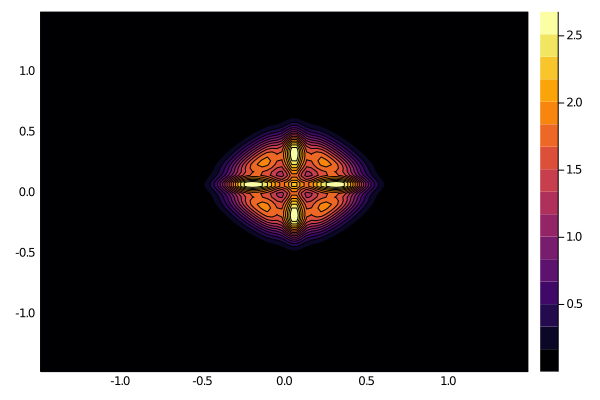

In [117]:
contourf(pspace.x[1:nx,1], pspace.y[1,1:ny], ρ[:,:])